In [2]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

In [3]:
'''
This function finds the descents indices in a sequence
'''
def find_descents_in_sequence(sequence):
    descents = []
    for i in range(0, len(sequence)-1):
        if sequence[i] > sequence[i + 1]:
            descents.append(i+1) #change from 0 to 1 indexing for plotting reasons
    return descents, True

# Example sequence
sequence = [4, 6, 3, 8, 7, 7, 2]

# Find and print descents
descents = find_descents_in_sequence(sequence)
print("Positions of descents:", descents)

Positions of descents: ([2, 4, 6], True)


In [4]:
import sympy as sp

def compute_coefficients(b):
    t = sp.symbols('t')
    expansion = sp.series(1 / (1 - (1 - t)**b), t, 0, 21).removeO()
    # Get coefficients for m = -10 to 10
    coeffs = [expansion.coeff(t, n) for n in range(-10, 11)]
    return coeffs

b = 3  
coefficients = compute_coefficients(b)
coeff_dict = {m: coeff for m, coeff in enumerate(coefficients, start=-10)}
size = 6
kernel_matrix = np.zeros((size, size))

for i in range(size):
    for j in range(size):
        m = j - i  
        # Convert the sympy Rational to a float before assigning
        kernel_matrix[i, j] = float(coeff_dict.get(m, 0))

print(kernel_matrix) # this is the Kernel Matric for Random Descent Indices



[[ 0.33333333  0.22222222  0.11111111  0.03703704  0.         -0.01234568]
 [ 0.33333333  0.33333333  0.22222222  0.11111111  0.03703704  0.        ]
 [ 0.          0.33333333  0.33333333  0.22222222  0.11111111  0.03703704]
 [ 0.          0.          0.33333333  0.33333333  0.22222222  0.11111111]
 [ 0.          0.          0.          0.33333333  0.33333333  0.22222222]
 [ 0.          0.          0.          0.          0.33333333  0.33333333]]


In [5]:
def bernoulli_trial(p):
    return np.random.rand() < p

def poulson_dpp_sampling(K):
    n = K.shape[0]
    sample = []
    A = np.array(K, dtype=float)

    for j in range(n):
        if bernoulli_trial(A[j, j]):
            sample.append(j+1)
        else:
            A[j, j] -= 1 
        A[j+1:n, j] /= A[j, j]  
        A[j+1:n, j+1:n] -= np.outer(A[j+1:n, j], A[j, j+1:n])
    return sample, A


In [6]:
sample, A = poulson_dpp_sampling(kernel_matrix)
print(sample)

[1, 4]


In [7]:
kernel_matrix

array([[ 0.33333333,  0.22222222,  0.11111111,  0.03703704,  0.        ,
        -0.01234568],
       [ 0.33333333,  0.33333333,  0.22222222,  0.11111111,  0.03703704,
         0.        ],
       [ 0.        ,  0.33333333,  0.33333333,  0.22222222,  0.11111111,
         0.03703704],
       [ 0.        ,  0.        ,  0.33333333,  0.33333333,  0.22222222,
         0.11111111],
       [ 0.        ,  0.        ,  0.        ,  0.33333333,  0.33333333,
         0.22222222],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.33333333,
         0.33333333]])

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def distr_of_indices(empirical_function, kernel_matrix):
    n_samples = 1000000
    # Generate sequences
    sequences = [np.random.randint(1, 4, size=7) for _ in range(n_samples)]  
    # Calculate empirical descent frequencies
    empirical_values = []
    ret_emprical = []
    ret_dpp = []
    for seq in sequences:
        descents, is_valid = empirical_function(seq)
        empirical_values.extend(descents)  
        ret_emprical.append(descents)
    sample_counts =[]  
    for i in range(0,n_samples):
        sample, _ = poulson_dpp_sampling(kernel_matrix)
        sample_counts.extend(sample)
        ret_dpp.append(sample)

   
     # Count the frequency of each index
    empirical_freq = Counter(empirical_values)
    sample_freq = Counter(sample_counts)

    # Normalize the frequencies by dividing by the total number of samples
    empirical_normalized = {k: v / len(empirical_values) for k, v in empirical_freq.items()}
    sample_normalized = {k: v / len(sample_counts) for k, v in sample_freq.items()}
    # Prepare the data for plotting
    indices = range(1, 7)
    empirical_data = [empirical_normalized.get(i, 0) for i in indices]
    sample_data = [sample_normalized.get(i, 0) for i in indices]
    
    # Set the positions and width for the bars
    pos = np.arange(len(indices))
    bar_width = 0.35

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(15, 10))
    bars1 = ax.bar(pos - bar_width/2, empirical_data, bar_width, label='Empirical Frequencies', color='blue')
    bars2 = ax.bar(pos + bar_width/2, sample_data, bar_width, label='DPP Sampled Frequencies', color='orange')

    # Adding the text on top of the bars
    def add_values_on_bars(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.6f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_values_on_bars(bars1)
    add_values_on_bars(bars2)

    # Adding labels and title
    ax.set_xticks(pos)
    ax.set_xticklabels([str(i) for i in indices])
    ax.set_xlabel('Position in Sequence')
    ax.set_ylabel('Proportion')
    ax.set_title('Normalized Comparison of Descent Frequencies')
    plt.legend()

    # print("--------------")
    # print(ret_emprical)
    # print(ret_dpp)
    # Show the plot
    plt.tight_layout()
    # plt.show()
    return ret_emprical, ret_dpp, empirical_freq, sample_freq
    


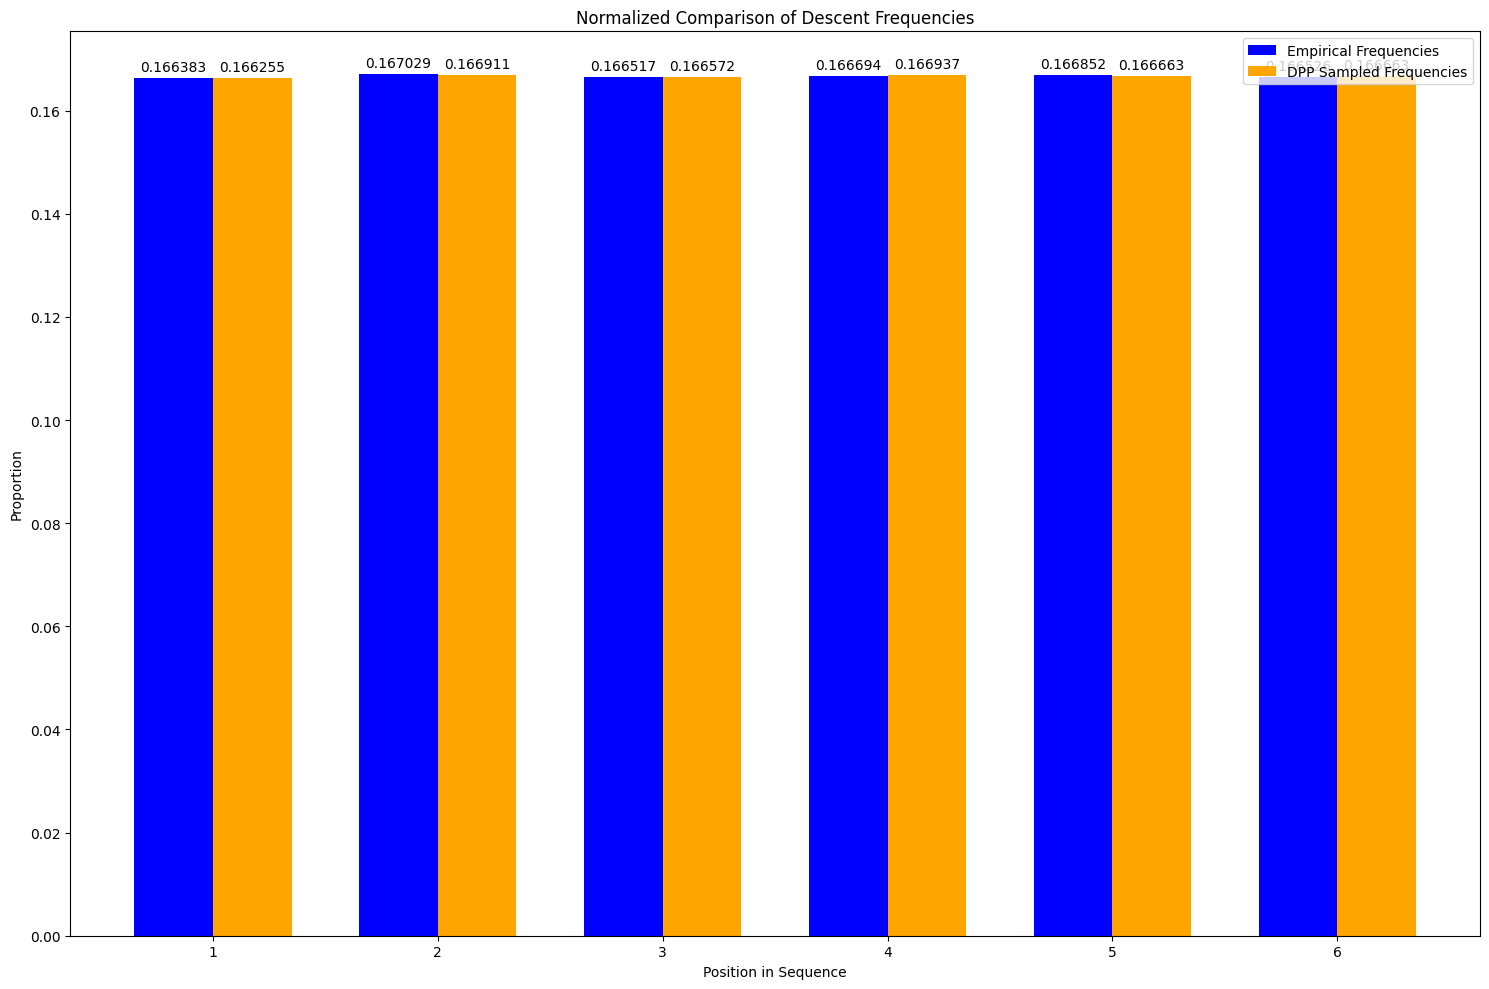

In [9]:
ret_emprical, ret_dpp, empirical_freq, sample_freq = distr_of_indices(find_descents_in_sequence, kernel_matrix)

In [14]:
print(empirical_freq)
print(sample_freq)

Counter({6: 333680, 3: 333559, 2: 333476, 4: 333373, 1: 333300, 5: 333211})
Counter({4: 333729, 1: 333697, 2: 333577, 6: 333568, 5: 333405, 3: 332730})


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_nth_largest_index(empirical_function, kernel_matrix, n):
    n_samples = 1000000
    # Generate sequences
    sequences = [np.random.randint(1, 4, size=7) for _ in range(n_samples)]  
    # Calculate empirical descent frequencies
    nth_largest_empirical = []
    nth_largest_sample = []
    
    for seq in sequences:
        descents, is_valid = empirical_function(seq)
        if len(descents) >= n:
            nth_largest_empirical.append(sorted(descents, reverse=True)[n-1])  

    for i in range(0,n_samples):
        sample, _ = poulson_dpp_sampling(kernel_matrix)
        if len(sample) >= n:
            nth_largest_sample.append(sorted(sample, reverse=True)[n-1])

    # Count the frequency of each nth largest index
    empirical_freq = Counter(nth_largest_empirical)
    sample_freq = Counter(nth_largest_sample)

    # Normalize the frequencies
    empirical_normalized = {k: v / len(nth_largest_empirical) for k, v in empirical_freq.items()}
    sample_normalized = {k: v / len(nth_largest_sample) for k, v in sample_freq.items()}

    # Prepare the data for plotting
    indices = range(1, max(max(nth_largest_empirical), max(nth_largest_sample)) + 1)
    empirical_data = [empirical_normalized.get(i, 0) for i in indices]
    sample_data = [sample_normalized.get(i, 0) for i in indices]
    
    # Plotting
    pos = np.arange(len(indices))
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(15, 10))
    bars1 = ax.bar(pos - bar_width/2, empirical_data, bar_width, label='Empirical Frequencies', color='blue')
    bars2 = ax.bar(pos + bar_width/2, sample_data, bar_width, label='DPP Sampled Frequencies', color='orange')

    # Add values on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Labels and title
    ax.set_xticks(pos)
    ax.set_xticklabels([str(i) for i in indices])
    ax.set_xlabel('Nth Largest Index')
    ax.set_ylabel('Proportion')
    ax.set_title('Normalized Frequencies of Nth Largest Indices')
    plt.legend()

    plt.tight_layout()
    plt.show()

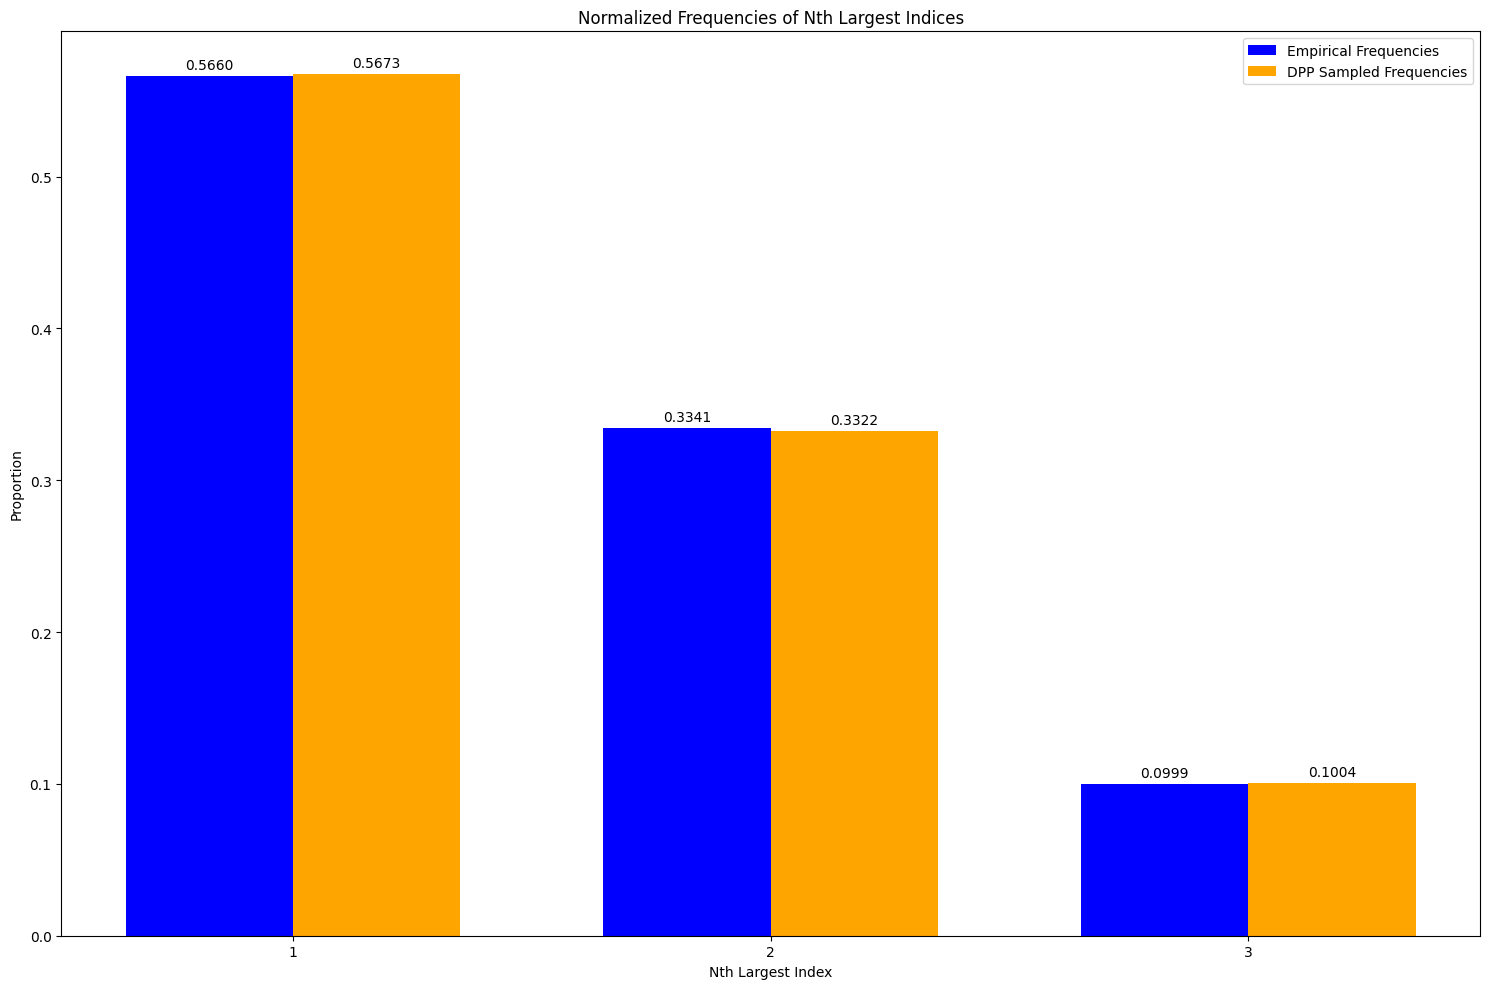

In [16]:
plot_nth_largest_index(find_descents_in_sequence, kernel_matrix, n=3)

In [72]:
def distr_of_indices_L(empirical_function, kernel_matrix, s):
    num_samples = 1000000
    all_descents = []
    
    # Generate descents until we have enough valid samples
    while len(all_descents) < num_samples:
        valid_descents = False
        while not valid_descents:
            seq = np.random.randint(1, 4, size=7)  # Generate a random sequence
            descents,_ = empirical_function(seq)
            if all(d < s for d in descents):
                valid_descents = True
                all_descents.extend(descents)
            
    shifted_samples = []
    while len(shifted_samples) < num_samples:  # ensuring we collect enough samples
        sample, _ = poulson_dpp_sampling(kernel_matrix)
        shifted_samples.extend(sample)

    descent_count = Counter(all_descents)
    sample_count = Counter(shifted_samples)

    total_empirical = sum(descent_count.values())
    total_sampled = sum(sample_count.values())
    # Data for plotting (only considering the first two indices)
    empirical_data = [descent_count.get(i, 0) / total_empirical for i in range(1, s)]
    sample_data = [sample_count.get(i, 0) / total_sampled for i in range(1, s)]

    # Indices for plotting
    indices = np.arange(1, s)  # Indices from 1 to 2
    pos = np.arange(len(indices))
    bar_width = 0.35

    # Setup plot
    fig, ax = plt.subplots(figsize=(15, 10))
    bars1 = ax.bar(pos - bar_width/2, empirical_data, bar_width, label='Empirical Frequencies', color='blue')
    bars2 = ax.bar(pos + bar_width/2, sample_data, bar_width, label='DPP Sampled Frequencies', color='orange')

    # Add values on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Labels and title
    ax.set_xticks(pos)
    ax.set_xticklabels([str(i) for i in indices])
    ax.set_xlabel('Nth Largest Index')
    ax.set_ylabel('Proportion')
    ax.set_title('Complement Frequencies')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [73]:
def compute_K_prime(K, s):
    # Calculate L = K(I - K)^-1
    I = np.eye(K.shape[0])  # Identity matrix of the same dimension as K
    try:
        L = K @ np.linalg.inv(I - K)
    except np.linalg.LinAlgError:
        raise ValueError("Matrix (I - K) is singular and cannot be inverted.")
    # Extract the submatrix of L up to the index s (assuming 0-based indexing, exclusive of s)
    L_ss = L[:(s-1), :(s-1)]
    # Compute K' = L[s,s] / (I + L[s,s])
    I_ss = np.eye(s-1)  # Identity matrix of the dimension specified by s
    K_prime = L_ss @ np.linalg.inv(I_ss + L_ss)
    
    return K_prime,L

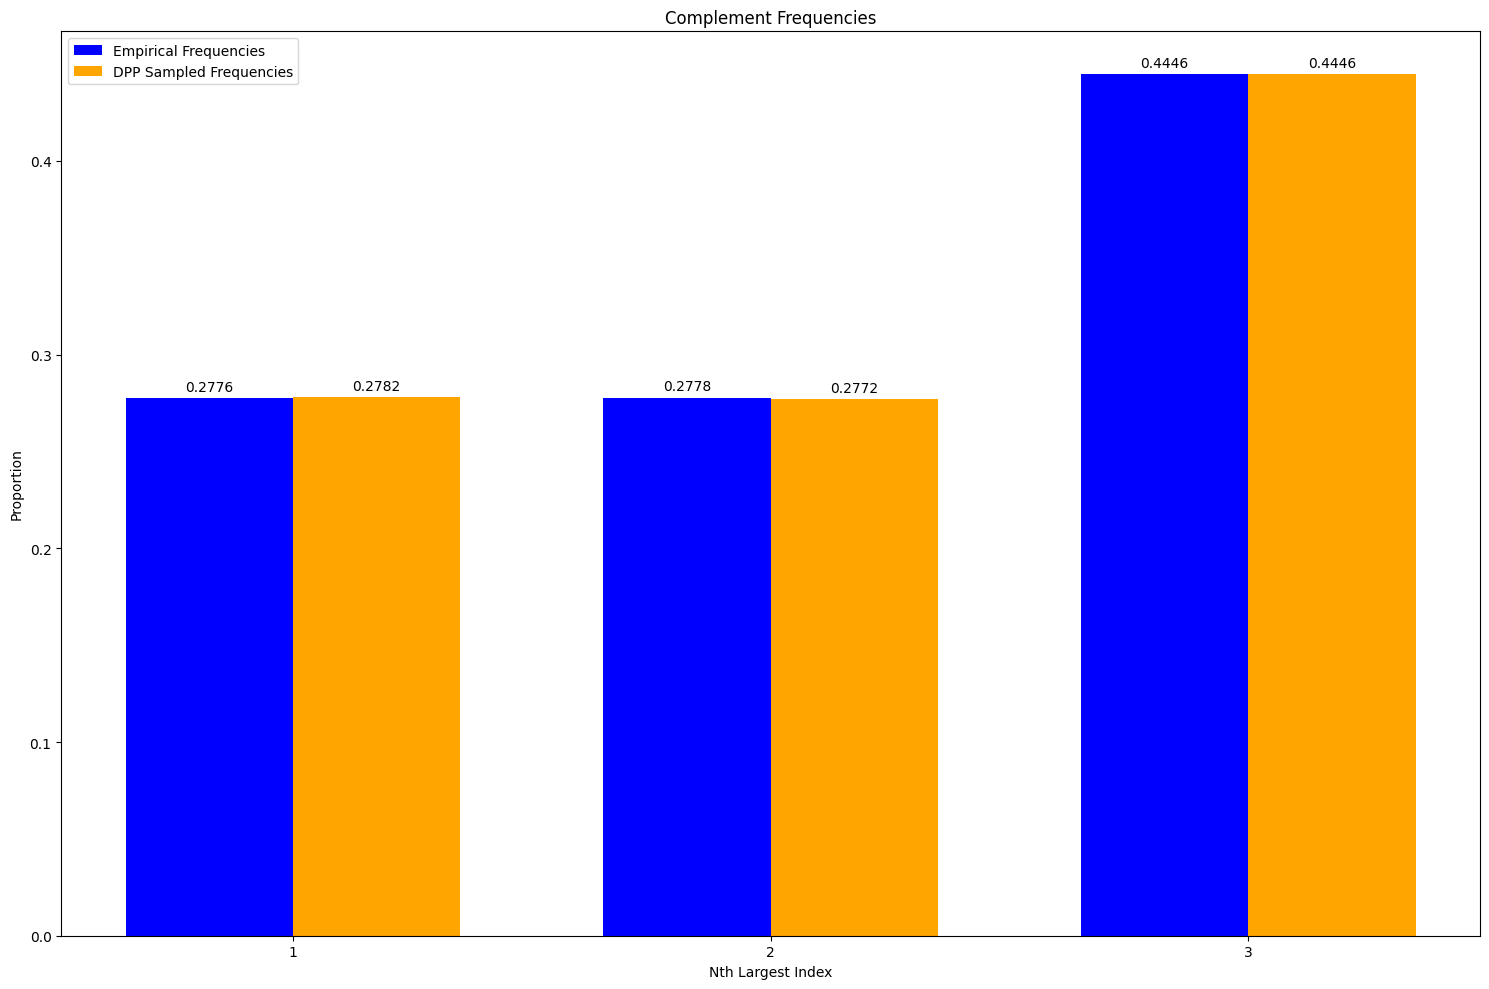

In [74]:
s = 4
K_prime,L = compute_K_prime(kernel_matrix,s)
distr_of_indices_L(find_descents_in_sequence, K_prime, s)

In [79]:
def distr_of_indices_K(empirical_function, kernel_matrix, s):
    num_samples = 1000000
    all_descents = []
    
    # Generate descents until we have enough valid samples
    while len(all_descents) < num_samples:
        seq = np.random.randint(1, 4, size=7)  # Generate a random sequence
        descents, _ = empirical_function(seq)
        # Filter out values of descents that are greater than or equal to s
        filtered_descents = [d for d in descents if d < s]
        all_descents.extend(filtered_descents)
        
    shifted_samples = []
    while len(shifted_samples) < num_samples:  # ensuring we collect enough samples
        sample, _ = poulson_dpp_sampling(kernel_matrix)
        shifted_samples.extend(sample)

    descent_count = Counter(all_descents)
    sample_count = Counter(shifted_samples)

    total_empirical = sum(descent_count.values())
    total_sampled = sum(sample_count.values())
    # Data for plotting (only considering the first two indices)
    empirical_data = [descent_count.get(i, 0) / total_empirical for i in range(1, s)]
    sample_data = [sample_count.get(i, 0) / total_sampled for i in range(1, s)]

    # Indices for plotting
    indices = np.arange(1, s)  # Indices from 1 to 2
    pos = np.arange(len(indices))
    bar_width = 0.35

    # Setup plot
    fig, ax = plt.subplots(figsize=(15, 10))
    bars1 = ax.bar(pos - bar_width/2, empirical_data, bar_width, label='Empirical Frequencies', color='blue')
    bars2 = ax.bar(pos + bar_width/2, sample_data, bar_width, label='DPP Sampled Frequencies', color='orange')

    # Add values on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Labels and title
    ax.set_xticks(pos)
    ax.set_xticklabels([str(i) for i in indices])
    ax.set_xlabel('Nth Largest Index')
    ax.set_ylabel('Proportion')
    ax.set_title('Restricted Frequencies')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [77]:
def compute_K_prime_prime(K, s):
    # Calculate L = K(I - K)^-1
    return K[:(s-1), :(s-1)]

In [47]:
compute_K_prime_prime(kernel_matrix,s)

array([[0.33333333, 0.22222222],
       [0.33333333, 0.33333333]])

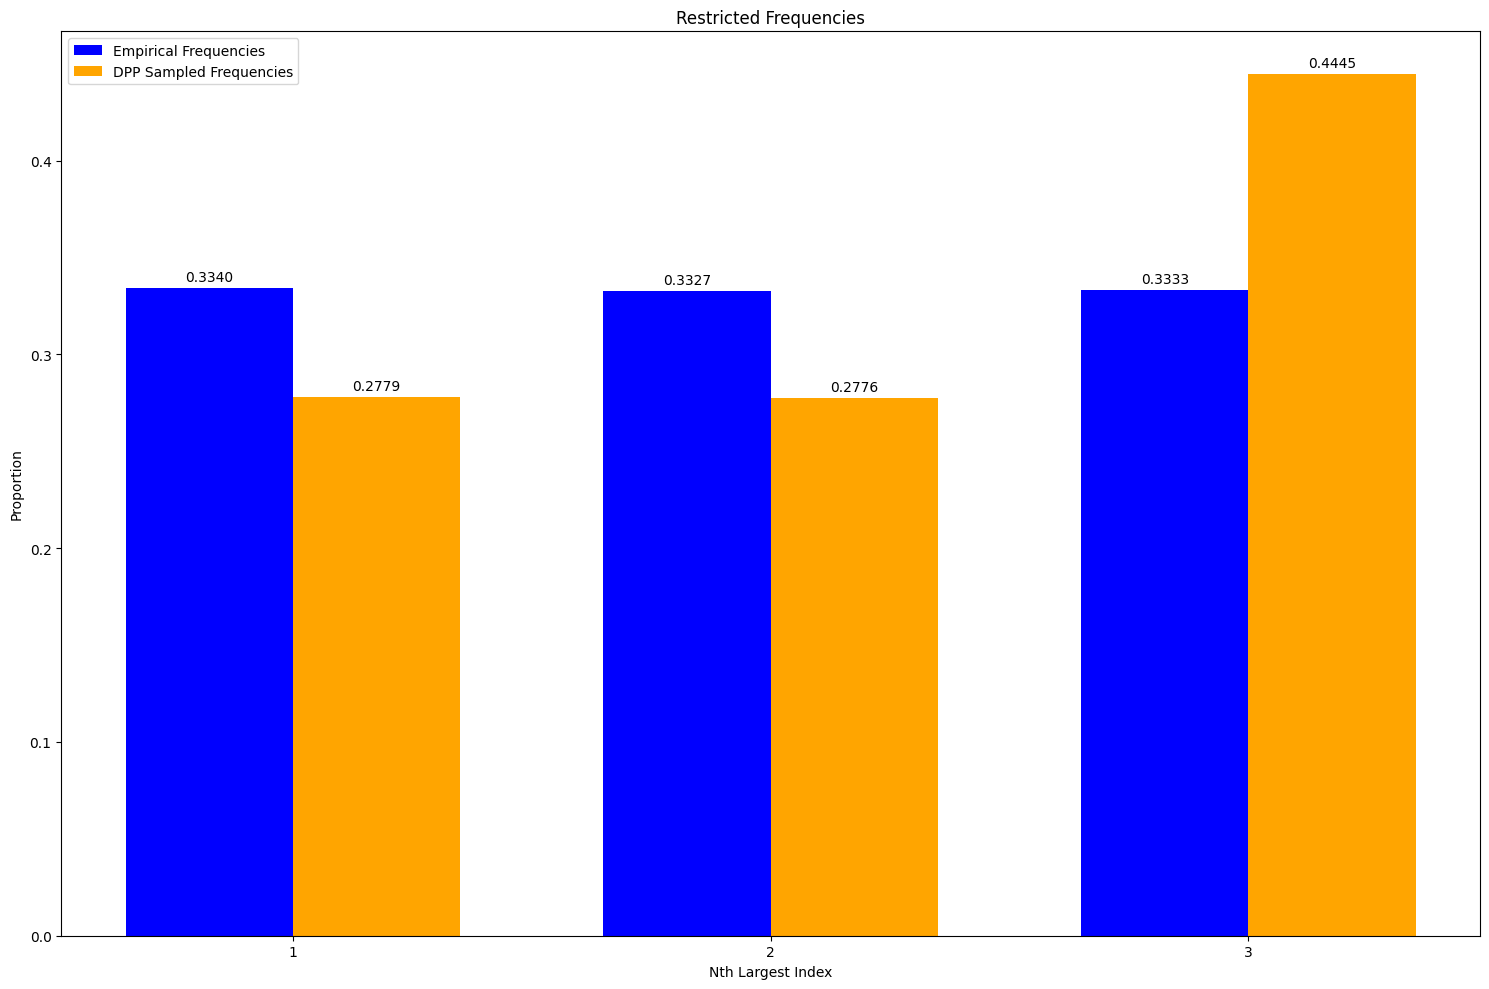

In [82]:
s = 4
K = compute_K_prime_prime(kernel_matrix,s)
distr_of_indices_K(find_descents_in_sequence, K, s)

In [ ]:
samples = []
for _ in range(1000):  # Adjust the number of iterations as needed
    sample, _ = poulson_dpp_sampling(kernel_matrix)
    samples.append(sample)

# Check the number of non-empty samples
non_empty_samples = [s for s in samples if s]
print(f"Number of non-empty samples: {len(non_empty_samples)}")

Number of non-empty samples: 0


In [80]:
import sympy as sp
import numpy as np

def compute_coefficients(b):
    t = sp.symbols('t')
    # Adjust the series expansion order if necessary
    expansion = sp.series(1 / (1 - (1 - t)**b), t, 0, 21).removeO()
    coeffs = [expansion.coeff(t, n) for n in range(-10, 11)]
    return coeffs

b = 3
coefficients = compute_coefficients(b)
coeff_dict = {m: coeff for m, coeff in enumerate(coefficients, start=-10)}
size = 6

# Set precision to desired number of decimal places
precision = 50

kernel_matrix = np.zeros((size, size), dtype=float)  # Use float for decimal precision

for i in range(size):
    for j in range(size):
        m = j - i
        coeff = coeff_dict.get(m, 0)
        # Convert the sympy Rational to a Decimal with the specified precision
        kernel_matrix[i, j] = float(sp.N(coeff, n=precision))

print(kernel_matrix)

[[ 0.33333333  0.22222222  0.11111111  0.03703704  0.         -0.01234568]
 [ 0.33333333  0.33333333  0.22222222  0.11111111  0.03703704  0.        ]
 [ 0.          0.33333333  0.33333333  0.22222222  0.11111111  0.03703704]
 [ 0.          0.          0.33333333  0.33333333  0.22222222  0.11111111]
 [ 0.          0.          0.          0.33333333  0.33333333  0.22222222]
 [ 0.          0.          0.          0.          0.33333333  0.33333333]]


In [180]:
import numpy as np

def find_descents_in_sequence(seq, s=None):
    descents = [i+1 for i in range(len(seq) - 1) if seq[i] > seq[i + 1]]
    return descents

sequences = [np.random.randint(1, 4, size=7) for _ in range(1000000)]

all_descents = []
max_descent_indices = []  # To store maximum descent index for each valid sequence
no_descent_count = 0  # To count sequences without descents
for seq in sequences:
    descents = find_descents_in_sequence(seq)
    all_descents.extend(descents)
    if descents:
        max_descent_indices.append(max(descents))
    else:
        no_descent_count += 1

# Calculating cumulative probabilities
cumulative_probabilities = {f"<{i}": sum(np.array(max_descent_indices) < i) / len(sequences) for i in range(6, 0, -1)}
# Adding P(<7) as 1 since the maximum index in a sequence of length 7 cannot exceed 6
cumulative_probabilities["<7"] = 1.0
# Adjusting P(<1) to account for sequences without any descents
cumulative_probabilities["<1"] = no_descent_count / len(sequences)

# Calculating exact probabilities for P(max index = 6), P(max index = 5), ..., P(max index = 1)
exact_probabilities = {}
for i in range(6, 0, -1):
    exact_probabilities[f"={i}"] = cumulative_probabilities[f"<{i}"] - cumulative_probabilities.get(f"<{i-1}", 0.0)

print(cumulative_probabilities)
print(exact_probabilities)

{'<6': 0.650161, '<5': 0.354547, '<4': 0.168888, '<3': 0.070181, '<2': 0.022189, '<1': 0.016562, '<7': 1.0}
{'=6': 0.295614, '=5': 0.185659, '=4': 0.09870700000000002, '=3': 0.04799199999999999, '=2': 0.005627, '=1': 0.016562}


In [182]:
import numpy as np

# Initialize an empty dictionary to store the probabilities.
probabilities = {}
K = kernel_matrix

# Loop to calculate P(X<n) for n from 6 down to 1
for i in range(6, 0, -1):
    # Select the bottom right i x i submatrix of K.
    K_submatrix = K[i-1:, i-1:]
    print("----")
    print(i)
    print(K_submatrix)
    # Create an i x i identity matrix.
    I_submatrix = np.eye(len(K_submatrix))
    # Compute the matrix to take determinant of, I - K_submatrix.
    matrix_to_determine = I_submatrix - K_submatrix
    # Calculate the determinant.
    det = np.linalg.det(matrix_to_determine)
    # Store the probability in the dictionary.
    probabilities[f'<{i}'] = det


# Calculate the cumulative probabilities
cumulative_probabilities = probabilities.copy()
cumulative_probabilities['<7'] = 1.0

# Print out the cumulative probabilities
print("\nCumulative Probabilities:")
print(cumulative_probabilities)
exact_probabilities = {}
for i in range(6, 1, -1):
    exact_probabilities[f"={i}"] = cumulative_probabilities[f"<{i}"] - cumulative_probabilities[f"<{i-1}"]

# Since P(X<0) is 0, P(X=1) is just P(X<1)
exact_probabilities["=1"] = cumulative_probabilities["<1"]

# Print out the probabilities
print("\nCumulative Probabilities:")
print(cumulative_probabilities)
print("\nExact Probabilities:")
print(exact_probabilities)


----
6
[[0.33333333]]
----
5
[[0.33333333 0.22222222]
 [0.33333333 0.33333333]]
----
4
[[0.33333333 0.22222222 0.11111111]
 [0.33333333 0.33333333 0.22222222]
 [0.         0.33333333 0.33333333]]
----
3
[[0.33333333 0.22222222 0.11111111 0.03703704]
 [0.33333333 0.33333333 0.22222222 0.11111111]
 [0.         0.33333333 0.33333333 0.22222222]
 [0.         0.         0.33333333 0.33333333]]
----
2
[[0.33333333 0.22222222 0.11111111 0.03703704 0.        ]
 [0.33333333 0.33333333 0.22222222 0.11111111 0.03703704]
 [0.         0.33333333 0.33333333 0.22222222 0.11111111]
 [0.         0.         0.33333333 0.33333333 0.22222222]
 [0.         0.         0.         0.33333333 0.33333333]]
----
1
[[ 0.33333333  0.22222222  0.11111111  0.03703704  0.         -0.01234568]
 [ 0.33333333  0.33333333  0.22222222  0.11111111  0.03703704  0.        ]
 [ 0.          0.33333333  0.33333333  0.22222222  0.11111111  0.03703704]
 [ 0.          0.          0.33333333  0.33333333  0.22222222  0.11111111]
 [ 